In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import pytz
import warnings

warnings.filterwarnings('ignore')

Lets load some stuff

In [3]:
events = pd.read_csv("D:\Projects\Kaggle\Brain\events.csv", index_col=0)

C:\Users\Andy\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [114]:
len(events)

23119793

Just over 23million records, this is pretty sizable

In [115]:
events.dtypes

document_id      int32
timestamp        int64
platform          int8
geo_location    object
country         object
dtype: object

In [5]:
events.describe()

,document_id,timestamp
count,2.312013e+07,2.312013e+07
mean,1.732563e+06,6.540050e+08
std,7.939175e+05,3.770036e+08
min,2.000000e+00,6.100000e+01
25%,1.163119e+06,3.178619e+08
50%,1.852756e+06,6.603422e+08
75%,2.370846e+06,9.783219e+08
max,2.999321e+06,1.296000e+09


Our csv's are quite large for my computer, so lets try to save as much memory as possible. document_id is int64, so lets change that to int32

In [6]:
events.document_id = events.document_id.astype(np.int32)

Lets take a look at what some of this data actually looks like

In [7]:
events.head(5)

,uuid,document_id,timestamp,platform,geo_location
display_id,,,,,
1,cb8c55702adb93,379743,61,3,US>SC>519
2,79a85fa78311b9,1794259,81,2,US>CA>807
3,822932ce3d8757,1179111,182,2,US>MI>505
4,85281d0a49f7ac,1777797,234,2,US>WV>564
5,8d0daef4bf5b56,252458,338,2,SG>00


So we have 
* display_id, which appears to be a series 
* uuid which are the user id's 
* document_id which is an id attached to more information that we will see later 
* timestamp that is the amount of time passed in seconds from when they first decided to collect data
* platform which tells us what type of device the user is viewing from
* geo_location, which gives us a country code, and in some cases a state/province/area code

Lets take a quick look at the distribution of where our users are coming from, and which platform they are using

I'm not going to use uuid right now, so lets just get rid of it

In [8]:
events = events.drop('uuid', 1)

Let's also make sure there is no funny business happening with platform

In [9]:
events.platform.unique()

array([3, 2, 1, '2', '1', '3', '\\N'], dtype=object)

Okay, so clearly there is something happening, we have an odd 'NA' string, as well some of the platforms are in string format and others in int, we probably could have guessed this was the case because its dtype=object, when you would have expected a factor or int

In [11]:
events.loc[events['platform'] == '3'] = 3
events.loc[events['platform'] == '2'] = 2
events.loc[events['platform'] == '1'] = 1
events.loc[events['platform'] == '\\N'] = np.NaN

In [12]:
#Something really weird is happening here I think, we are inexplicably changing datatypes by replacing 
#values from the previous step
events.dtypes

document_id     float64
timestamp       float64
platform         object
geo_location     object
dtype: object

Lets see how many NaN values we have, this will determine what we do with them

In [28]:
events.platform.isnull().sum()

5

5 is tiny compared to the size of our dataset, lets just get rid of all rows with NaN values

In [29]:
events = events.dropna(axis = 0)

In [30]:
events.platform = events.platform.astype(np.int8)
events.document_id = events.document_id.astype(np.int32)
events.timestamp = events.timestamp.astype(np.int64)
events.dtypes

C:\Users\Andy\Anaconda3\lib\site-packages\pandas\core\generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


document_id      int32
timestamp        int64
platform          int8
geo_location    object
dtype: object

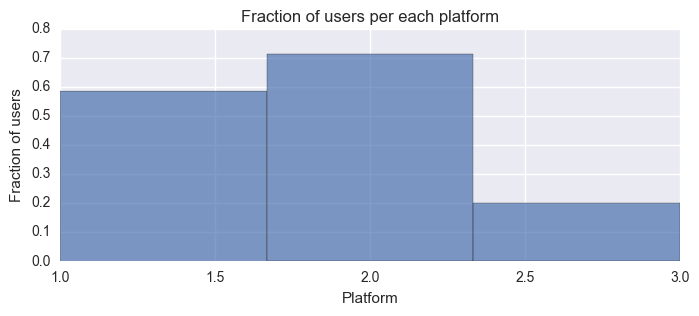

In [38]:
plt.figure(figsize = (8,3))
events.platform.hist(bins = 3, alpha = 0.7, normed = True)
plt.xlim(1,3)
plt.title("Fraction of users per each platform")
plt.xlabel("Platform")
plt.ylabel("Fraction of users")
plt.show()

Looks like most of our users use platform 1 and 2, which corresponds to Desktop and Mobile, with only about 20% using a tablet.

Now lets try and take a look what the country data looks like.

In [41]:
#We will use some of the finer grained geo_location information later, so lets start off by creating a copy column containing
#Only the country code

events['country'] = events.geo_location.str[:2]

C:\Users\Andy\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [42]:
events.head(4)

,document_id,timestamp,platform,geo_location,country
display_id,,,,,
1,379743,61,3,US>SC>519,US
2,1794259,81,2,US>CA>807,US
3,1179111,182,2,US>MI>505,US
4,1777797,234,2,US>WV>564,US


In [111]:
country_count = events.groupby('country')['country'].count().sort_values()
country_count = pd.DataFrame(country_count)

Lets get a percentage value for how many events are coming from which country, and take a look at the top 10

In [112]:
country_count = country_count.iloc[::-1]
country_count['Percentage'] = 100*country_count.country/country_count.country.sum()
country_count['CumulativePercentage'] = 100*country_count.country.cumsum()/country_count.country.sum()
country_count.columns = ['Events', 'Percentage', 'CumulativePercentage']
country_count.head(10)

,Events,Percentage,CumulativePercentage
country,,,
US,18064325,80.412984,80.412984
CA,1182719,5.264850,85.677834
GB,1082109,4.816987,90.494821
AU,472344,2.102630,92.597451
IN,222974,0.992564,93.590015
NZ,108090,0.481160,94.071176
ZA,107925,0.480426,94.551602
PH,83675,0.372478,94.924080
SG,80440,0.358077,95.282157


Okay, so an overwhealming majority of events are coming from the US, and the top ten countries represent over 95% of all traffic. That's pretty cool

Now maybe lets combine what we have and try to see if there are interesting relationships between how users from each country view content.

First, lets get rid of all records outside the top ten, because they are insignificant in number by comparison.

In [133]:
del country_count
top_ten = events.country.value_counts()[:10]
events = events.loc[events.country.isin(top_ten.index)]

Lets take a look how the different countries view content

country
TV    3
IO    3
NU    4
NR    4
Name: country, dtype: int64

In [134]:
count_stuff = events.groupby(['platform', 'country'])['country'].count()

In [135]:
count_stuff.tail(10)

platform  country
1         CA          225470
          US         1837047
2         CA          203022
          US         3062710
3         CA           99570
          US          588976
Name: country, dtype: int64

In [130]:
events.country.describe()

count     6016795
unique          2
top            US
freq      5488733
Name: country, dtype: object

In [138]:
events.country.describe()

count     6016795
unique          2
top            US
freq      5488733
Name: country, dtype: object

In [ ]:
plt.figure(figsize = (12,4))
pd.tools.plotting.radviz(events 